# Classification
#### Brage Wiseth, Eirik Jahr, Felix Cameren

In [1]:
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))

key = jax.random.PRNGKey(2024)


jax backend gpu


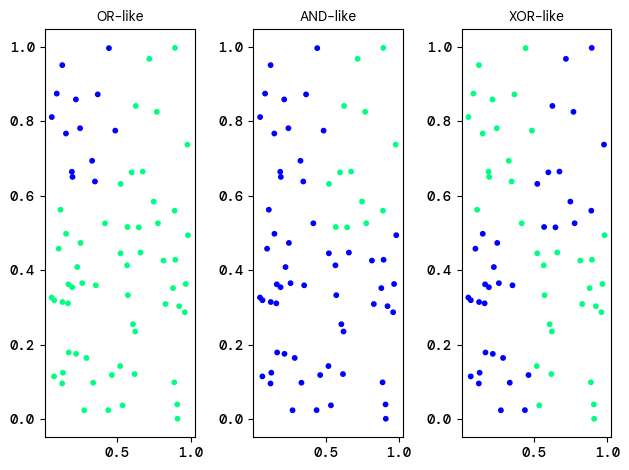

In [2]:
# we can generate a OR-like , AND-like and XOR-like dataset with float values
x = jax.random.uniform(key, shape=(70,2), minval=0, maxval=1)

t_or = (x[:,0] >= 0.5) | (x[:,1] < 0.6)
t_and = (x[:,0] >= 0.5) & (x[:,1] > 0.5)
t_xor = (x[:,0] >= 0.5) ^ (x[:,1] > 0.5)


fig, ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0],x[:,1], s=10, c=t_or, cmap='winter')
ax[0].set_title("OR-like", font='sans')
ax[1].scatter(x[:,0],x[:,1], s=10, c=t_and, cmap='winter')
ax[1].set_title("AND-like", font='sans')
ax[2].scatter(x[:,0],x[:,1], s=10, c=t_xor, cmap='winter')
ax[2].set_title("XOR-like", font='sans')
fig.tight_layout()
plt.show()


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler() # not using it for now

X_train, X_test, t_or_train, t_or_test = train_test_split(x, t_or, test_size=0.2, random_state=1234)
# same seed so we only need x_train and x_test from the first split
_ , _,   t_and_train , t_and_test = train_test_split(x, t_and, test_size=0.2, random_state=1234)
_ , _,   t_xor_train , t_xor_test = train_test_split(x, t_xor, test_size=0.2, random_state=1234)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

t_or_train = np.asarray(t_or_train).reshape(-1, 1)
t_or_test = np.asarray(t_or_test).reshape(-1, 1)
t_and_train = np.asarray(t_and_train).reshape(-1, 1)
t_and_test = np.asarray(t_and_test).reshape(-1, 1)
t_xor_train = np.asarray(t_xor_train).reshape(-1, 1)
t_xor_test = np.asarray(t_xor_test).reshape(-1, 1)


### ADAMLL is a local library for machine learning algorithms it contains activation functions, cost functions, and optimization algorithms from previous exercises.

In [4]:
import ADAMLL as ada

#### test and compare with jax to verify the derivations, not used in the analysis

In [5]:

loss = ada.CE

def sigmoid_derivative(x):
    return x * (1.0 - x)



def loss_all_args(w0,w1, b0, b1, X, T):
    """
    Loss function
    """
    a0 = ada.activations.sigmoid(X @ w0 + b0)
    a1 = ada.activations.sigmoid(a0 @ w1 + b1)
    return loss(a1, T)



# key, subkey = jax.random.split(key)
# params = ada.init_network_params([2,1], subkey)
# print(params)
# activations = forward_propagate(params, x)
# print(activations)
# print(t_train)
# grads = backprop_one_hidden(params, t_train, forward_propagate(params, X_train))
# grads = single_layer_gradients(params, t_train, forward_propagate(params, X_train))

# print(grads)
# print("#####")
# print(jax.grad(loss_all_args,argnums=(0,1,2,3))(params[0]['w'], params[1]['w'], params[0]['b'], params[1]['b'], X_train, t_train))

## Running the Neural Network

#### No hidden layer

In [6]:
sigmoid = ada.activations.sigmoid

sgd = ada.NN.NN(architecture=[[2,1],[ sigmoid ]], eta=0.05, epochs=400, tol=0.001, optimizer='adam', gamma=0.3,backwards=ada.NN.single_layer_gradients, loss=ada.CE )

loss_or, params_or = sgd.fit(X_train, t_or_train, X_test, t_or_test)
loss_and, params_and = sgd.fit(X_train, t_and_train, X_test, t_and_test)
loss_xor, params_xor = sgd.fit(X_train, t_xor_train, X_test, t_xor_test)

Training stopped after 399 epochs                                     

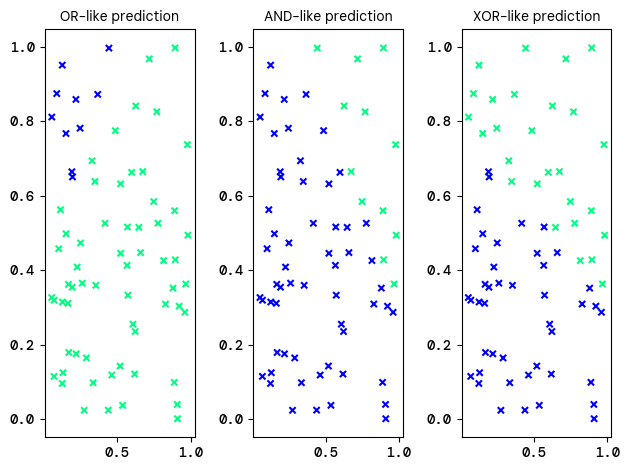

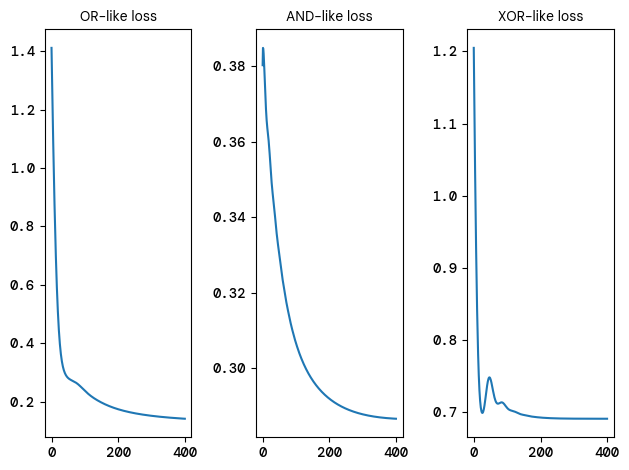

In [7]:


def predict(activations):
    return np.round(activations)


y_or = sgd.forward(params_or, x)[-1]
y_and = sgd.forward(params_and, x)[-1]
y_xor = sgd.forward(params_xor, x)[-1]


y_or = predict(y_or)
y_and = predict(y_and)
y_xor = predict(y_xor)


fig , ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0], x[:,1], s=20, c=y_or, cmap='winter', marker='x')
ax[0].set_title("OR-like prediction", font='sans')
ax[1].scatter(x[:,0], x[:,1], s=20, c=y_and, cmap='winter', marker='x')
ax[1].set_title("AND-like prediction", font='sans')
ax[2].scatter(x[:,0], x[:,1], s=20, c=y_xor, cmap='winter', marker='x')
ax[2].set_title("XOR-like prediction", font='sans')
fig.tight_layout()


fig, ax = plt.subplots(1, 3)
ax[0].plot(loss_or)
ax[0].set_title("OR-like loss", font='sans')
ax[1].plot(loss_and)
ax[1].set_title("AND-like loss", font='sans')
ax[2].plot(loss_xor)
ax[2].set_title("XOR-like loss", font='sans')
fig.tight_layout()
plt.show()

### One hidden layer

In [15]:
sigmoid = ada.activations.sigmoid

sgd = ada.NN.NN(architecture=[[2,4, 1],[ sigmoid, sigmoid ]], eta=0.05, epochs=400, tol=0.001, optimizer='adam', gamma=0.3, beta1=0.9, beta2=0.999, backwards=ada.NN.backprop_one_hidden, loss=ada.CE )
loss_or, params_or = sgd.fit(X_train, t_or_train, X_test, t_or_test)
loss_and, params_and = sgd.fit(X_train, t_and_train, X_test, t_and_test)
loss_xor, params_xor = sgd.fit(X_train, t_xor_train, X_test, t_xor_test)

Training stopped after 399 epochs                                     

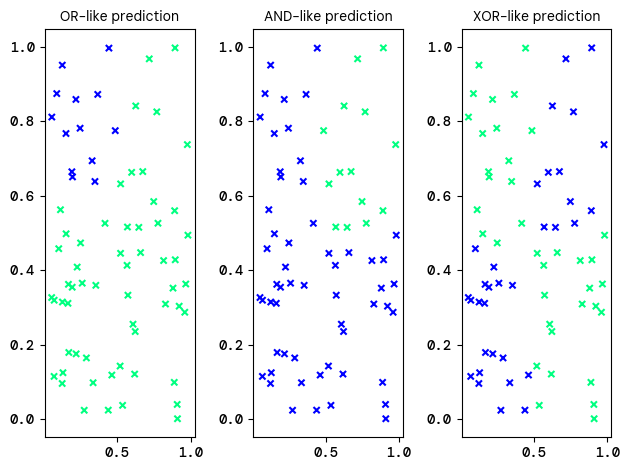

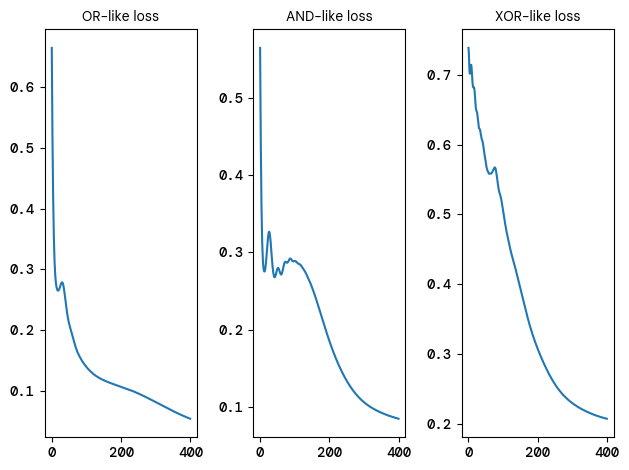

In [16]:
y_or = sgd.forward(params_or, x)[-1]
y_and = sgd.forward(params_and, x)[-1]
y_xor = sgd.forward(params_xor, x)[-1]


y_or = predict(y_or)
y_and = predict(y_and)
y_xor = predict(y_xor)


fig , ax = plt.subplots(1, 3)
ax[0].scatter(x[:,0], x[:,1], s=20, c=y_or, cmap='winter', marker='x')
ax[0].set_title("OR-like prediction", font='sans')
ax[1].scatter(x[:,0], x[:,1], s=20, c=y_and, cmap='winter', marker='x')
ax[1].set_title("AND-like prediction", font='sans')
ax[2].scatter(x[:,0], x[:,1], s=20, c=y_xor, cmap='winter', marker='x')
ax[2].set_title("XOR-like prediction", font='sans')
fig.tight_layout()


fig, ax = plt.subplots(1, 3)
ax[0].plot(loss_or)
ax[0].set_title("OR-like loss", font='sans')
ax[1].plot(loss_and)
ax[1].set_title("AND-like loss", font='sans')
ax[2].plot(loss_xor)
ax[2].set_title("XOR-like loss", font='sans')
fig.tight_layout()
plt.show()